# Single-cell data and scanpy

The principles of dimensionality reduction can be applied to any data type or format. One of the most common applications is to reduce single-cell data to two dimensions for visualization. You can apply the methods directly, as we have in other notebooks, or you can make use of packages that will do most of this for you. Two of the most common include `scanpy` (for Python) and `seurat` (for R). For the purposes of this workshop, we will use `scanpy`. These libraries generally do not have methods built-in, but rather are a collection of tools that call other libraries. So rather than performing PCA manually using `sk-learn`, UMAP using `umap-learn`, and plotting with `matplotlib`, the `scanpy` package builds functions to call them independently.

There are trade-offs in using these types of packages versus the using the methods independently. The most important thing, however, is **you should always work to understand what your methods are doing!**

**Advantages**

* Prepared packages can save you time as part of a larger set of experiments or analysis pipelines
* If packages are well-maintained you can avoid issues like dependency hell
* Large libraries have active communities that can help you, whereas maintainers of specific libraries like UMAP may not be able to help with problems specific to your project

**Disadvantages**

* You can end up treating your methods like a black box. You shouldn't do this&mdash;make sure you understand what your method is doing and how it's doing it!
* Doing dimensionality reduction and visualization directly can give you more control over your parameters and methods and potentially uncover signal in your data that you would otherwise ignore.
* You may still end up in dependency hell and it can be more difficult to troubleshoot because there are more moving parts to address.

**Other notes**

* This is a very active area of research! There are many debates about which methods to use and why (one example: [The art of using t-SNE for single-cell transcriptomics](https://www.nature.com/articles/s41467-019-13056-x) followed by [The specious art of single-cell genomics](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1011288) followed by [The art of seeing the elephant in the room: 2D embeddings of single-cell data do make sense](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10996625/))
* One of the most common applications is cluster analysis. In some cases researchers will cluster data based on gene counts and then carry our gene-count-based analyses on those same clusters. This can cause problems! See: [Neufeld, Anna, et al. "Inference after latent variable estimation for single-cell RNA sequencing data." Biostatistics 25.1 (2024): 270-287.](https://academic.oup.com/biostatistics/article-abstract/25/1/270/68939530)

# Example

In [167]:
# Import libraries
import scanpy as sc
from matplotlib.pyplot import rc_context # Manager to handle matplotlib parameters
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.set_figure_params(dpi=100, color_map="viridis_r") # Set basic visualization parameters
sc.settings.verbosity = 0 
sc.logging.print_header() # Print what versions you're using

scanpy==1.10.4 anndata==0.11.3 umap==0.5.7 numpy==2.1.3 scipy==1.15.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 pynndescent==0.5.13


This example dataset uses peripheral blood mononuclear cells (PBMCs), which are a variety of blood cells. This is real data! Since it is relatively well-studied, it is commonly used in tutorials. The full dataset has over $68,000$ cells with thousands of markers. For this tutorial, we'll use $700$ cells with $765$ of the most highly-variable genes. All of the processing has helpfully been done for us; if you're interested in more details, see the "References" section in the `scanpy` documentation, linked at the bottom of this notebook.

If you're interested in playing with other data sources, there are hundreds available online in many libraries such as:

* [10x Genomics](https://www.10xgenomics.com/datasets?configure%5BhitsPerPage%5D=50&configure%5BmaxValuesPerFacet%5D=1000)
* [The Broad Institute](https://singlecell.broadinstitute.org/single_cell)
* [The Allen Brain Atlas](https://portal.brain-map.org/atlases-and-data/bkp/abc-atlas)

These are all real data sources used in actual studies, and there are many, many more available online. This field is growing rapidly and there is no shortage of discoveries to be made. If you are curious, I highly recommend finding an interesting dataset and using your skills from this workshop to explore it.

## PBMCs

In [6]:
pbmc = sc.datasets.pbmc68k_reduced() # Import the PBMC data

We can examine the object to see its properties. `scanpy` uses an `AnnData` class. You can find more information [here](https://anndata.readthedocs.io).

In [21]:
pbmc # Check the object

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can look at some of the details of cells by calling the object.

In [46]:
pbmc.obs["bulk_labels"] # Cell labels (i.e. cell types)

index
AAAGCCTGGCTAAC-1     CD14+ Monocyte
AAATTCGATGCACA-1          Dendritic
AACACGTGGTCTTT-1           CD56+ NK
AAGTGCACGTGCTA-1    CD4+/CD25 T Reg
ACACGAACGGAGTG-1          Dendritic
                         ...       
TGGCACCTCCAACA-8          Dendritic
TGTGAGTGCTTTAC-8          Dendritic
TGTTACTGGCGATT-8    CD4+/CD25 T Reg
TTCAGTACCGGGAA-8            CD19+ B
TTGAGGTGGAGAGC-8          Dendritic
Name: bulk_labels, Length: 700, dtype: category
Categories (10, object): ['CD4+/CD25 T Reg', 'CD4+/CD45RA+/CD25- Naive T', 'CD4+/CD45RO+ Memory', 'CD8+ Cytotoxic T', ..., 'CD19+ B', 'CD34+', 'CD56+ NK', 'Dendritic']

In [24]:
pbmc.obs["n_genes"] # Number of genes counted in each cell

index
AAAGCCTGGCTAAC-1    1003
AAATTCGATGCACA-1    1080
AACACGTGGTCTTT-1    1228
AAGTGCACGTGCTA-1    1007
ACACGAACGGAGTG-1    1178
                    ... 
TGGCACCTCCAACA-8    1166
TGTGAGTGCTTTAC-8    1014
TGTTACTGGCGATT-8    1079
TTCAGTACCGGGAA-8    1030
TTGAGGTGGAGAGC-8    1552
Name: n_genes, Length: 700, dtype: int64

One of the most common analyses is clustering cell data. Scanpy uses the [Louvain method](https://en.wikipedia.org/wiki/Louvain_method) by default, which optimizes non-overlapping communities (i.e. it optimizes a function that divides all data points into mutually exclusive groups). Other common clustering methods include [k-means](https://en.wikipedia.org/wiki/K-means_clustering) and density-based methods such as [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN).

In [27]:
# See Louvain cluster labels
pbmc.obs["louvain"]

index
AAAGCCTGGCTAAC-1    1
AAATTCGATGCACA-1    1
AACACGTGGTCTTT-1    3
AAGTGCACGTGCTA-1    9
ACACGAACGGAGTG-1    2
                   ..
TGGCACCTCCAACA-8    2
TGTGAGTGCTTTAC-8    1
TGTTACTGGCGATT-8    0
TTCAGTACCGGGAA-8    4
TTGAGGTGGAGAGC-8    2
Name: louvain, Length: 700, dtype: category
Categories (11, object): ['0', '1', '2', '3', ..., '7', '8', '9', '10']

The PCA and UMAP embeddings are stored in `obsm`. These coordinates are what we plot for our visualizations.

In [34]:
pbmc.obsm["X_umap"], pbmc.obsm["X_pca"]

(array([[ -1.99186255,   8.57641706],
        [ -3.24869194,   7.99994913],
        [ -3.59310303,  -2.22675898],
        ...,
        [ -5.98349489,  -5.86929568],
        [-12.35074674,  -4.4339864 ],
        [  5.90649366,  -3.57606702]]),
 array([[-7.939618  ,  5.024914  ,  2.9037306 , ..., -3.228536  ,
         -0.60592127,  0.9732133 ],
        [-7.7352414 ,  4.33796   ,  1.4893486 , ..., -1.8452125 ,
         -0.01023911,  0.07135285],
        [ 9.590969  ,  6.409222  , -8.308694  , ..., -1.3177946 ,
         -0.61671865,  1.3843659 ],
        ...,
        [ 4.928574  ,  1.2381667 ,  0.53577584, ...,  0.7577447 ,
          0.6433388 ,  1.4959103 ],
        [ 2.890713  , -6.116919  ,  3.9368765 , ...,  0.8674861 ,
          3.6986613 ,  1.0767299 ],
        [-5.7872367 , -5.0758386 , -4.112453  , ..., -1.1315929 ,
         -0.4941009 ,  0.64597267]], dtype=float32))

If you want to do a simple visualization, you can just use the methods from other notebooks. All of the values are stored as `AnnData` and can be retrieved. For example, if we want to retrieve the normalized gene counts for the gene [CD79A](https://en.wikipedia.org/wiki/CD79A) (a marker of [B-cells](https://en.wikipedia.org/wiki/B_cell)), we can do so.

In [173]:
# Look up where the gene counts are stored in the object
gene_name = "CD79A"
cd79a_idx = list(pbmc.raw.var_names).index(gene_name)

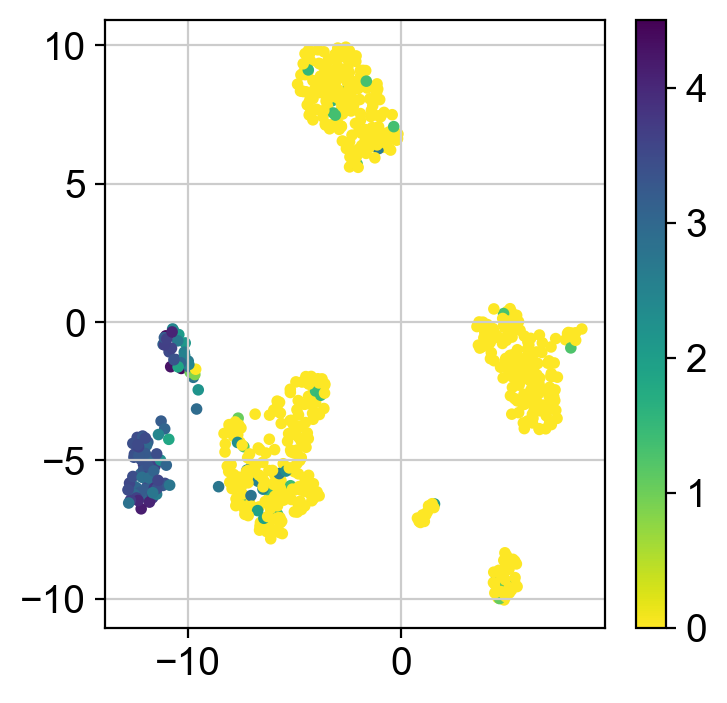

In [174]:
umap_coords = pbmc.obsm["X_umap"] # Assign the UMAP coordinates to a different object for convenience.

# Run a basic scatterplot using matplotlib
plt.scatter(
    x = umap_coords[:,0],
    y = umap_coords[:,1],
    s = 10,
    #c = pbmc.X[:,cd79a_idx] # Adjusted gene counts?
    c = np.array(pbmc.raw.X[:, cd79a_idx].todense())[:,0] # Raw gene counts?
)

# Add a colour bar to show the intensity of gene counts.
plt.colorbar()

You can do a lot of this instantly with `scanpy`, which has plotting modules that look for specific embeddings (e.g. PCA, UMAP, t-SNE) and can colour specific genes.

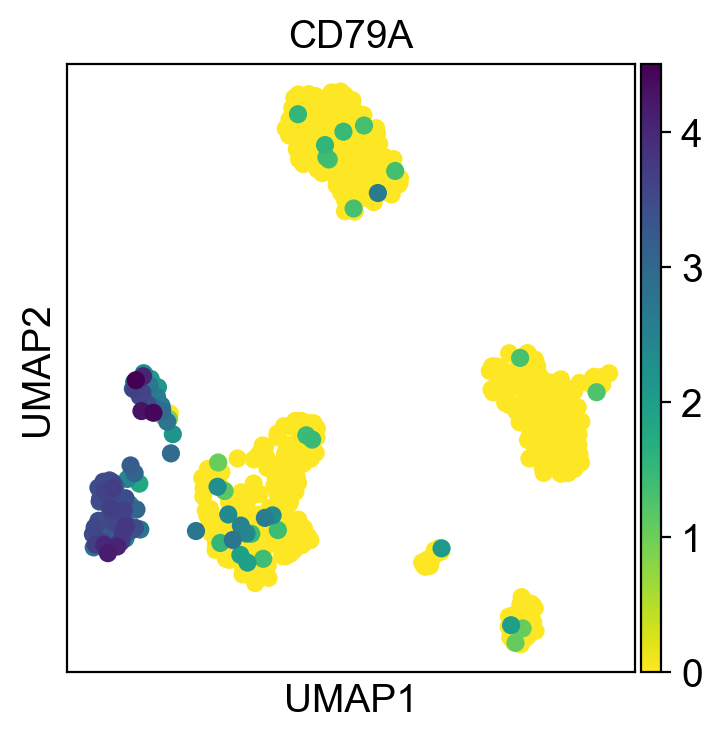

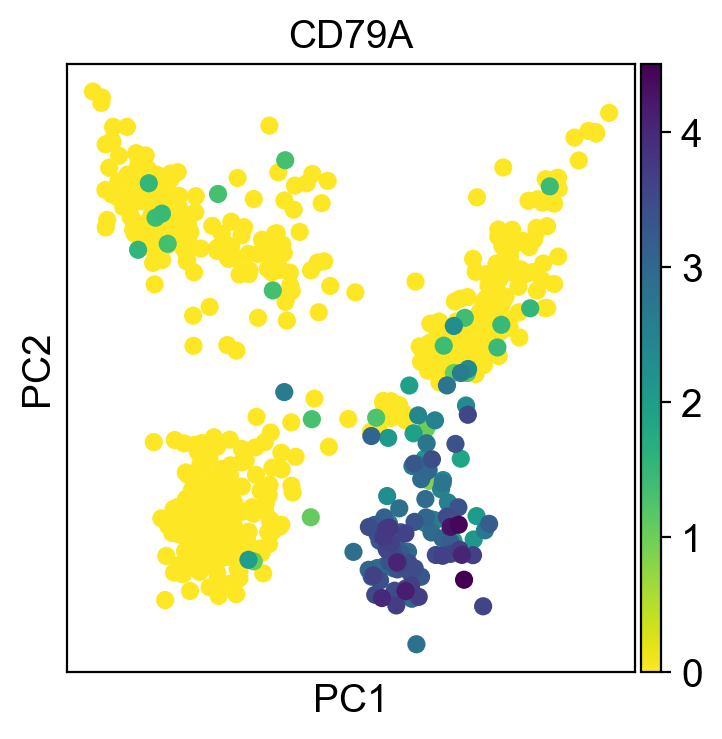

(None, None)

In [180]:
sc.pl.umap(pbmc, color="CD79A"), sc.pl.pca(pbmc, color="CD79A")

Note that this requires having the embedding in the object. For example, this object does not have a pre-generated t-SNE embedding, so `sc.pl.tsne` will not work.

The advantage of libraries like `scanpy` is that the code has been designed to save time for repetitive tasks like looking at multiple genes at once.

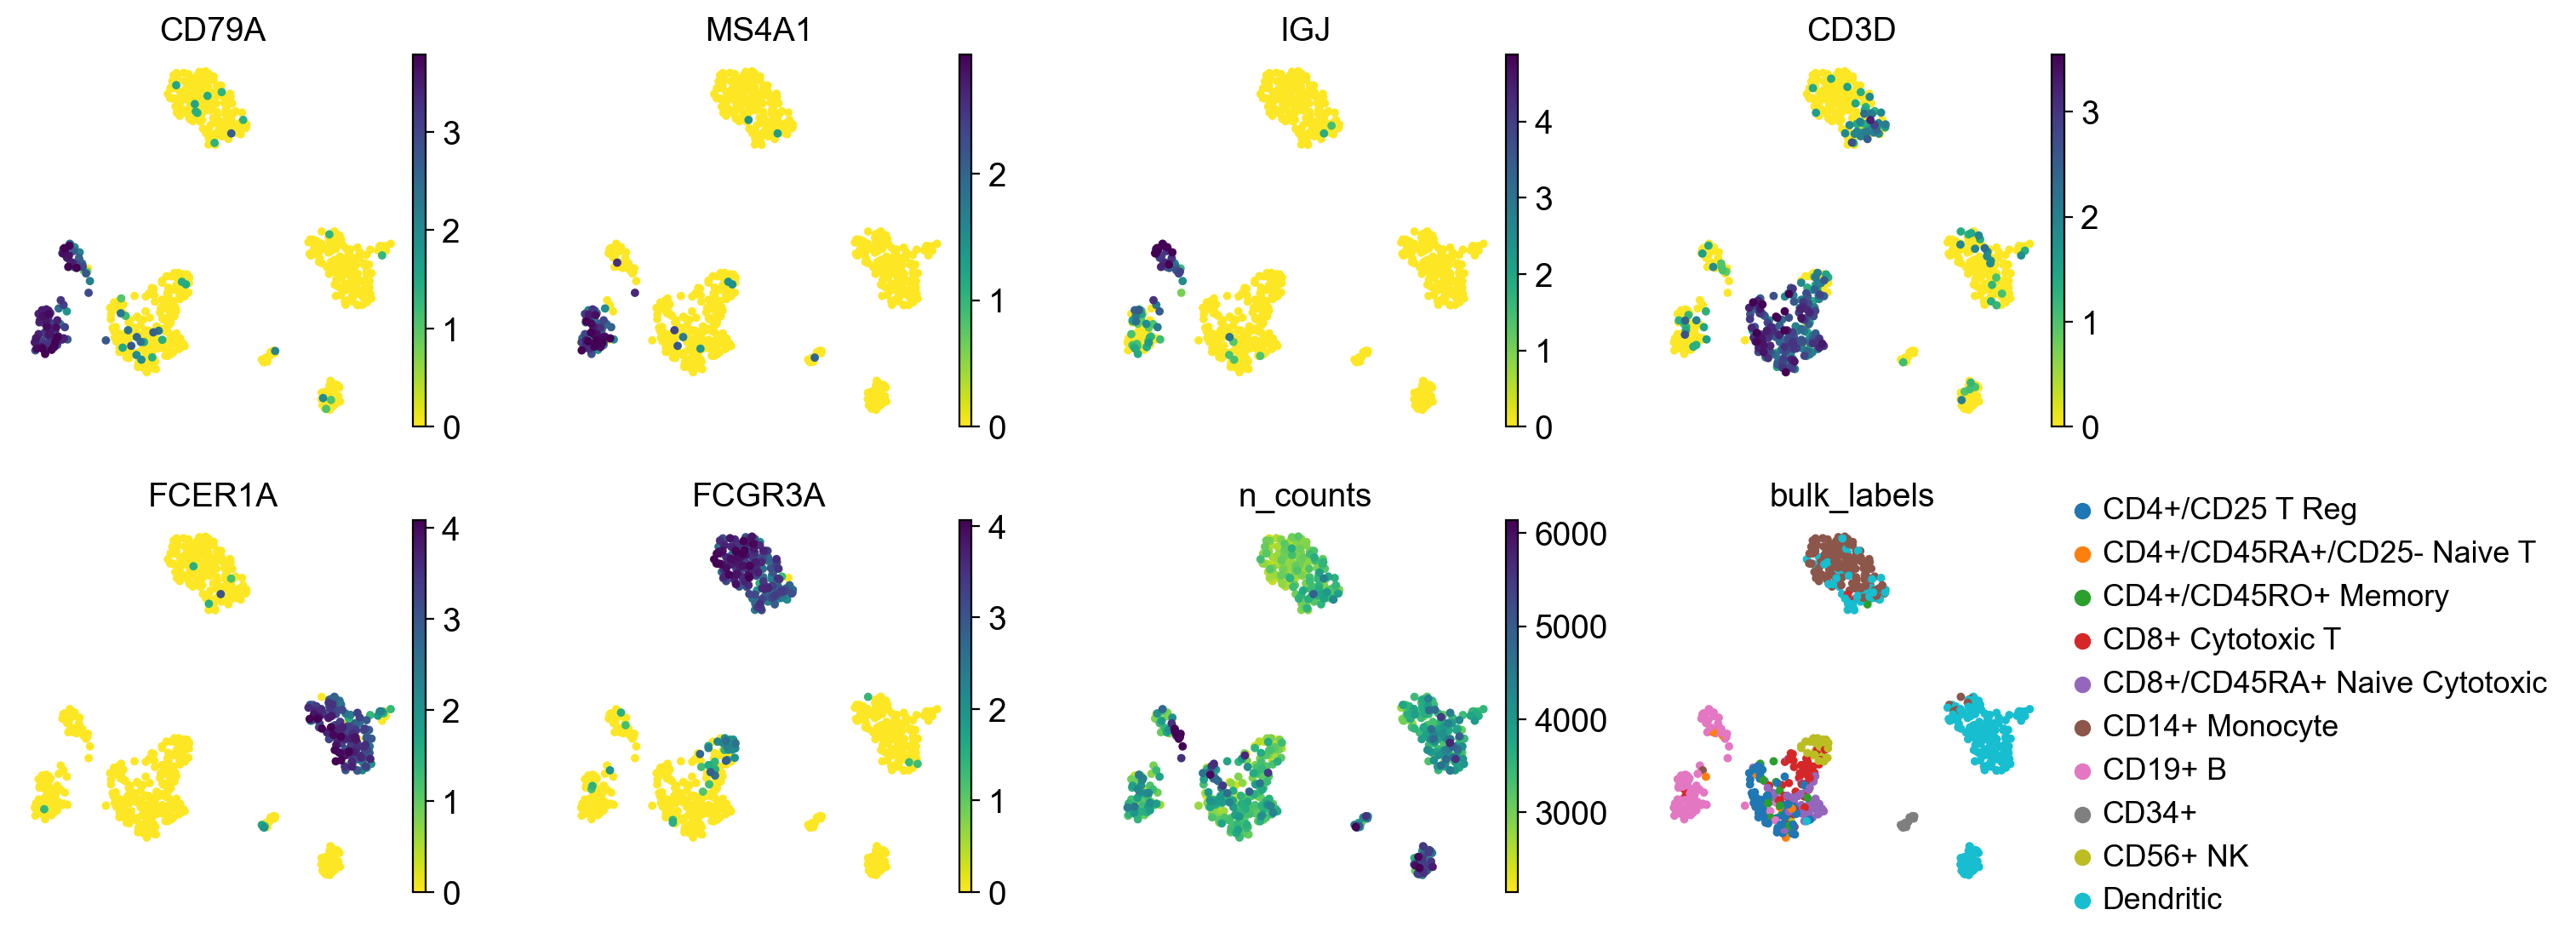

In [176]:
color_vars = [
    "CD79A",
    "MS4A1",
    "IGJ",
    "CD3D",
    "FCER1A",
    "FCGR3A",
    "n_counts",
    "bulk_labels",
]
with rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(pbmc, color=color_vars, s=50, frameon=False, ncols=4, vmax="p99")

Note that in the final plot (where we colour by cell type) we see the CD19+ B cells form clusters that correspond with CD79A.

Lastly, we can look at some cluster labels.

In [178]:
# compute clusters using the leiden method and store the results with the name `clusters`
sc.tl.leiden(
    pbmc,
    key_added="clusters",
    resolution=0.5,
    n_iterations=2,
    flavor="igraph",
    directed=False,
)

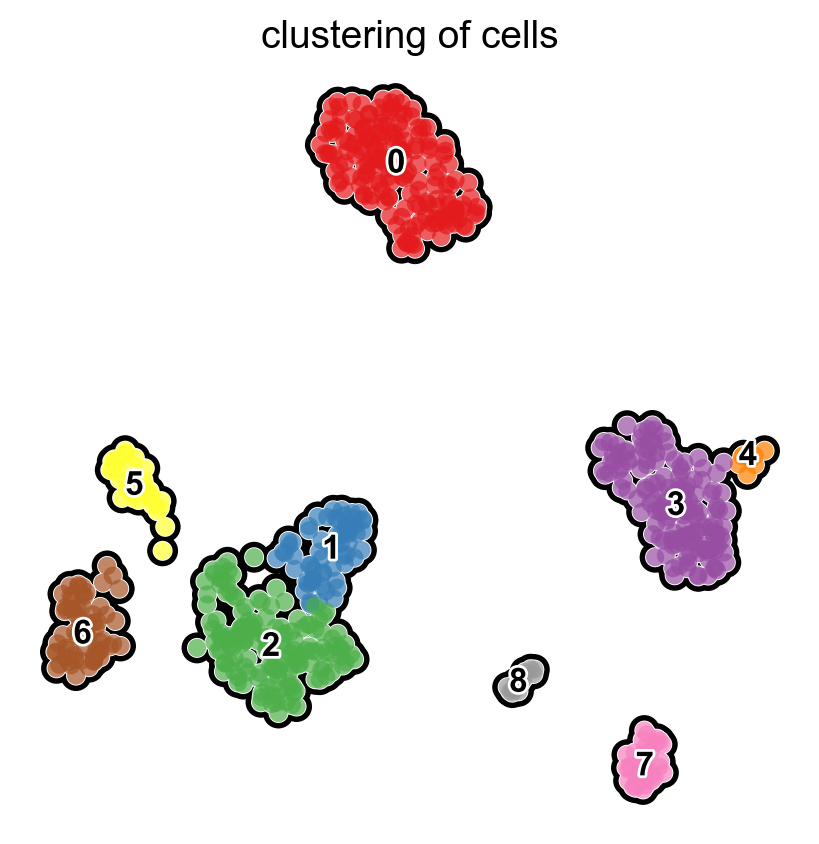

In [179]:
with rc_context({"figure.figsize": (5, 5)}):
    sc.pl.umap(
        pbmc,
        color="clusters",
        add_outline=True,
        legend_loc="on data",
        legend_fontsize=12,
        legend_fontoutline=2,
        frameon=False,
        title="clustering of cells",
        palette="Set1",
    )

# References
* This tutorial is based off of the [Scanpy documentation](https://scanpy.readthedocs.io/en/stable/tutorials/plotting/core.html). The notebook was written by Alex Diaz-Papkovich.
* [Wolf, F. Alexander, Philipp Angerer, and Fabian J. Theis. "SCANPY: large-scale single-cell gene expression data analysis." Genome biology 19 (2018): 1-5.](https://link.springer.com/article/10.1186/s13059-017-1382-0) (Scanpy paper)
* [Spatial reconstruction of single-cell gene expression data](https://www.nature.com/articles/nbt.3192): (Seurat paper)